In [1]:
import os
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import model_selection
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from xgboost import XGBClassifier, XGBRegressor, plot_importance, plot_tree

In [2]:
DATA_FOLDER = '/home/fanta/.kaggle/competitions/uci-wine-quality-dataset'

data = pd.read_csv(os.path.join(DATA_FOLDER, 'winequality-data.csv'))
solutions = pd.read_csv(os.path.join(DATA_FOLDER, 'winequality-solution-input.csv'))

In [3]:
data.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,id
0,6.7,0.15,0.38,1.7,0.037,20.0,84.0,0.99046,3.09,0.53,11.4,6,981
1,6.7,0.44,0.31,1.9,0.030,41.0,104.0,0.99000,3.29,0.62,12.6,7,982
2,6.1,0.17,0.21,1.9,0.090,44.0,130.0,0.99255,3.07,0.41,9.7,5,983
3,6.6,0.39,0.22,4.0,0.038,17.0,98.0,0.99018,3.25,0.53,13.0,7,984
4,6.8,0.32,0.34,6.0,0.050,5.0,129.0,0.99530,3.19,0.40,9.1,5,985


In [4]:
X = data.iloc[:, 0:11]
y = data.iloc[:, 11]

In [5]:
n_splits = 8
dataset_splitter = model_selection.KFold(n_splits=n_splits, shuffle=True)

In [6]:
X = X.values
y = y.values

In [7]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

estimators = ( linear_model.LinearRegression(),
              linear_model.LogisticRegression(), 
              linear_model.RidgeCV(alphas=[.01, .1, .5, 1]),
              pipeline.Pipeline([('poly',
                                  preprocessing.PolynomialFeatures(degree=3)),
                                 ('linear',
                                  linear_model.LinearRegression(fit_intercept=False))]),
              XGBClassifier(learning_rate=.1, n_estimators=200, max_depth=7, tree_method='gpu_exact')
             )
estimator_names = ('Linear Regression', 'Logistic Regression', 'Ridge Regression', 'Polynomial', 'XGB')

# Store training and validation loss for every fold
train_loss = np.zeros(len(estimators))
val_loss = np.zeros(len(estimators))

# Loop around the folds
for fold, (train_idx, val_idx) in enumerate(dataset_splitter.split(X, y)):
    # Loop around the estimators
    for estimator_idx, estimator in enumerate(estimators):

        # Split dataset between training and validation set
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        # print('Fold {}: X_train={} X_val={} y_train={} y_val={}'.format(fold, X_train.shape, X_val.shape, y_train.shape, y_val.shape))
        # Fit the model
        model = estimator
        model.fit(X_train, y_train)
        # Use the model to make predictions on the validation set, and compute the related loss
        y_val_pred = np.rint(model.predict(X_val)).astype(int)
        val_loss[estimator_idx] += metrics.mean_absolute_error(y_val, y_val_pred)
        # Same as above, but on the training set
        y_train_pred = np.rint(model.predict(X_train)).astype(int)
        train_loss[estimator_idx] += metrics.mean_absolute_error(y_train, y_train_pred)
        
train_loss /= n_splits
val_loss /= n_splits


In [8]:
train_loss

array([0.53529505, 0.53146672, 0.53048218, 0.43885378, 0.00142188])

In [9]:
val_loss

array([0.53829243, 0.5352333 , 0.53573985, 0.60894579, 0.38564803])

In [10]:
pd.Series(np.rint(estimators[4].predict(X))).value_counts()

6.0    1793
5.0    1164
7.0     688
8.0     131
4.0     123
3.0      15
9.0       4
dtype: int64

In [11]:
pd.Series(estimators[4].predict(X)).describe()

count    3918.000000
mean        5.874170
std         0.871787
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
dtype: float64

In [12]:
# Now training on the whole dataset, before submission
estimators[-1].fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='gpu_exact')

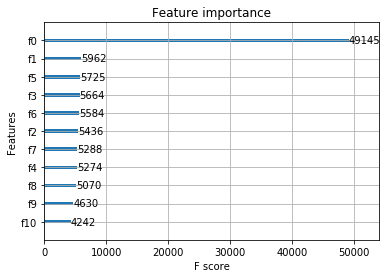

In [13]:
plot_importance(estimators[-1])

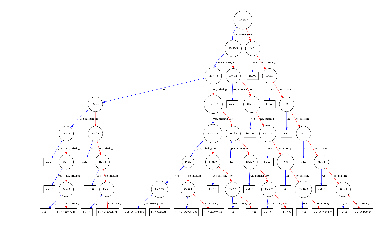

In [14]:
plot_tree(estimators[-1])

In [15]:
# Read in CSV for solution input:
soln = pd.read_csv("/home/fanta/.kaggle/competitions/uci-wine-quality-dataset/winequality-solution-input.csv")


In [16]:
X_sol = soln.iloc[:, 0:11].values
soln_predict_xgb = estimators[-1].predict(X_sol)

# Format as a submission and write as a CSV:
submission = pd.DataFrame(index = soln["id"],
                              data = {'quality': soln_predict_xgb})
submission.to_csv("winequality-submission-xgb.csv", index_label = "id")